In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker
from matplotlib import colormaps
from matplotlib.colors import Normalize

import numpy as np
import os, glob
import time
import warnings

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=1
# from rur.sci.kinematics import f_getpot

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle
import argparse, subprocess
from importlib import reload
import cmasher as cmr
from copy import deepcopy
from multiprocessing import Pool, shared_memory

mode = 'nh'
iout = 1026
repo, rurmode, dp = mode2repo(mode)
snap = uri.RamsesSnapshot(repo, iout, mode=rurmode)
snaps = uri.TimeSeries(snap)
snaps.read_iout_avail()
nout = snaps.iout_avail['iout']
gals = uhmi.HaloMaker.load(snap, galaxy=True, double_precision=dp)
hals = uhmi.HaloMaker.load(snap, galaxy=False, double_precision=dp)
database = f"/home/jeon/MissingSat/database"

[Output 01026] Age (Gyr) : 11.624 / 13.741, z = 0.17149 (a = 0.8536)


In [2]:
LG = pklload(f"{database}/LG")

In [3]:
allsubs = None
states = None
for key in LG.keys():
    subs = LG[key]['subs']
    real = LG[key]['real']
    dink = real[real['state']=='dink']['hid']
    ind = isin(subs['id'], dink)
    subs['dink'][ind] = True
    subs['dink'][~ind] = False
    state = np.zeros(len(subs), dtype='<U7')
    state[ind] = 'dink'
    state[~ind] = 'pair'
    upair = real[real['state']=='upair']['hid']
    ind = isin(subs['id'], upair)
    state[ind] = 'upair'

    allsubs = subs if allsubs is None else np.hstack((allsubs, subs))
    states = state if states is None else np.hstack((states, state))
argsort = np.argsort(allsubs['id'])
allsubs = allsubs[argsort]
states = states[argsort]
allsubs.dtype


dtype([('nparts', '<i4'), ('id', '<i4'), ('timestep', '<i4'), ('level', '<i4'), ('host', '<i4'), ('hostsub', '<i4'), ('nbsub', '<i4'), ('nextsub', '<i4'), ('aexp', '<f8'), ('m', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('vx', '<f8'), ('vy', '<f8'), ('vz', '<f8'), ('Lx', '<f8'), ('Ly', '<f8'), ('Lz', '<f8'), ('r', '<f8'), ('a', '<f8'), ('b', '<f8'), ('c', '<f8'), ('ek', '<f8'), ('ep', '<f8'), ('et', '<f8'), ('spin', '<f8'), ('sigma', '<f8'), ('rvir', '<f8'), ('mvir', '<f8'), ('tvir', '<f8'), ('cvel', '<f8'), ('rho0', '<f8'), ('rc', '<f8'), ('mcontam', '<f8'), ('r10_mem', '<f8'), ('r50_mem', '<f8'), ('r90_mem', '<f8'), ('r10_vir', '<f8'), ('r50_vir', '<f8'), ('r90_vir', '<f8'), ('r10_max', '<f8'), ('r50_max', '<f8'), ('r90_max', '<f8'), ('sub', '<i8'), ('dink', '?'), ('mdm', '<f8'), ('mstar', '<f8'), ('mcold', '<f8'), ('mcell', '<f8'), ('Host', '<i4'), ('r200kpc', '<f8'), ('m200', '<f8'), ('r200', '<f8'), ('mdm_vir', '<f8'), ('mstar_vir', '<f8'), ('mcell_vir', '<f8'), ('mcold_vi

In [4]:
fname = f"{database}/03_inner_slope.pickle"
density_slope = None
if(os.path.exists(fname)):
    density_slope = pklload(fname)

In [5]:
from scipy.optimize import curve_fit
def chisq(obs, exp, weight, ddof=0):
    ssres = np.sum( (obs-exp)**2 * weight) / np.sum(weight)
    mean = np.mean(obs)
    sstot = np.sum( (obs-mean)**2 * weight) / np.sum(weight)
    return 1 - ssres/sstot
def single(logr, const, gamma):
    # r = 10**logr
    return gamma * logr + const

In [6]:
np.min(allsubs['rvir'])/snap.unit['kpc']

1.8775363513689065

# Using member parts

In [7]:
if(density_slope is None):
    denslops = np.zeros(len(allsubs))
    densloperrs = np.zeros(len(allsubs))
    draw=True
    for j, table in tqdm( enumerate(allsubs), total=len(allsubs)):
        state = states[j]
        draw = not os.path.exists(f"{database}/photo/03_density_slope/inner_example_member_{state}.png")
        # draw = draw or (not os.path.exists(f"{database}/photo/03_density_slope/inner_weird_member_{state}.png"))
        memdm = uhmi.HaloMaker.read_member_part(snap, table['id'], galaxy=False, target_fields=['x','y','z','m'])
        mem_dist = distance(table, memdm)/snap.unit['kpc']; argsort = np.argsort(mem_dist)
        mem_dist = mem_dist[argsort]; mem_mass = memdm['m'][argsort]
        rvir_kpc = table['rvir']/snap.unit['kpc']
        leng = 15
        
        if(draw):
            rbins2 = np.logspace(np.log10(rvir_kpc/100), np.log10(rvir_kpc), leng+1) # kpc
            rx2 = (rbins2[1:] + rbins2[:-1])/2
            rhos2 = np.zeros(leng)
            mass2 = np.zeros(leng)
            nparts2 = np.zeros(leng)
            for i in range(leng):
                mask2 = (mem_dist >= rbins2[i]) & (mem_dist < rbins2[i+1])
                nparts2[i] = np.sum(mask2)
                mass_in_sphere2 = np.sum(mem_mass[mask2])/snap.unit['Msol']
                mass2[i] = mass_in_sphere2
                vol2 = sphere(rbins2[i+1]) - sphere(rbins2[i])
                rhos2[i] = mass_in_sphere2/vol2 # Msol/kpc^3
            mask2 = rhos2>0
            rx2 = rx2[mask2]; rhos2 = rhos2[mask2]; mass2 = mass2[mask2]; nparts2 = nparts2[mask2]
            ws2 = 1/np.sqrt(nparts2)
            rhoserr2 = rhos2 * ws2
            ws2 /= np.sum(ws2)
            fig,ax = plt.subplots()
            color = 'r' if(state=='dink') else 'b'
            ax.errorbar(rx2/rvir_kpc, rhos2, yerr=rhoserr2, ms=5, mec='grey',mfc='none', ecolor='grey', elinewidth=1, capsize=3, marker='s', lw=0)
        rbins = np.logspace(np.log10(rvir_kpc/100), np.log10(rvir_kpc/50), leng+1) # kpc
        if(rvir_kpc/50 < 0.5):
            rbins = np.logspace(np.log10(0.5), np.log10(2), leng+1)
        rx = (rbins[1:] + rbins[:-1])/2
        rhos = np.zeros(leng)
        mass = np.zeros(leng)
        nparts = np.zeros(leng)
        for i in range(leng):
            mask = (mem_dist >= rbins[i]) & (mem_dist < rbins[i+1])
            nparts[i] = np.sum(mask)
            mass_in_sphere = np.sum(mem_mass[mask])/snap.unit['Msol']
            mass[i] = mass_in_sphere
            vol = sphere(rbins[i+1]) - sphere(rbins[i])
            rhos[i] = mass_in_sphere/vol # Msol/kpc^3
        mask = rhos>0
        rx = rx[mask]; rhos = rhos[mask]; mass = mass[mask]; nparts = nparts[mask]
        ws = 1/np.sqrt(nparts)
        rhoserr = rhos * ws
        ws /= np.sum(ws)
        try: popt, pcov = curve_fit(single, np.log10(rx), np.log10(rhos), p0=[1, -2], bounds=([-np.inf, -3.5], [np.inf, 0.5]), sigma=ws, maxfev=5000, method='trf')
        except: popt = np.zeros(2)*np.nan; pcov = np.zeros((2,2))*np.nan
        chi = chisq( np.log10(rhos), single(np.log10(rx), *popt), ws, ddof=2)


        denslops[j] = popt[-1]
        # print(pcov,np.sqrt(np.diag(pcov))[-1])
        densloperrs[j] = np.sqrt(np.diag(pcov))[-1]
        if(draw):
            if(densloperrs[j]>=0.5):
                if not ((chi<0.5) and ((popt[-1]==-3.5)or(popt[-1]==0.5))):
                    draw=False
                    plt.close()

        if(draw):
            ax.errorbar(rx/rvir_kpc, rhos, yerr=rhoserr, ms=5, mec=color,mfc='none', ecolor=color, elinewidth=1, capsize=3, marker='s', zorder=2, lw=0)
            ax.plot(rx/rvir_kpc, 10**single(np.log10(rx), *popt), label=fr"[Inner] $\gamma$={popt[-1]:.2f}$\pm${np.sqrt(np.diag(pcov))[-1]:.2f}, $R^2$={chi:.4f}", ls='-', lw=2, color='black', zorder=3)
            ax.axvspan(ax.get_xlim()[0], 0.5/rvir_kpc, color='grey', alpha=0.2)
            ax.set_xscale('log')
            ax.set_yscale('log')

            ypos = 0.25
            ax.text(0.05, ypos, f"ID={table['id']} ({state})", ha='left', va='center', transform=ax.transAxes, color=color); ypos -= 0.05
            ax.text(0.05, ypos, fr"$\log(M_h/M_\odot)$={np.log10(table['m']):.2f}", ha='left', va='center', transform=ax.transAxes); ypos -= 0.05
            ax.text(0.05, ypos, fr"$\log(M_{{vir}}/M_\odot)$={np.log10(table['mvir']):.2f}", ha='left', va='center', transform=ax.transAxes); ypos -= 0.05
            ax.text(0.05, ypos, fr"$\log(M_{{200}}/M_\odot)$={np.log10(table['m200']):.2f}", ha='left', va='center', transform=ax.transAxes); ypos -= 0.05
            ax.text(0.05, ypos, fr"$R_{{vir}}$={table['rvir']/snap.unit['kpc']:.2f} kpc", ha='left', va='center', transform=ax.transAxes); ypos -= 0.05

            ax.legend()

            ax.set_xlabel(r'$R/R_{vir}$')
            ax.set_ylabel(r'$\rho$ [M$_\odot$ kpc$^{-3}$]')
            if(densloperrs[j]<0.5):
                plt.savefig(f"{database}/photo/03_density_slope/inner_example_member_{state}.png", dpi=400, bbox_inches='tight', pad_inches=0.1)
                plt.close()
            elif((chi<0.5) and ((popt[-1]==-3.5)or(popt[-1]==0.5))):
                plt.savefig(f"{database}/photo/03_density_slope/inner_weird_member_{state}.png", dpi=400, bbox_inches='tight', pad_inches=0.1)
                plt.close()
            plt.close()
else:
    denslops = density_slope['slope_mem']
    densloperrs = density_slope['err_mem']

  1%|          | 20/3851 [00:00<00:35, 107.46it/s]/home/jeon/.conda/envs/jeonpy/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_48986/1665795486.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - ssres/sstot
  1%|▏         | 52/3851 [00:00<00:27, 139.79it/s]

  2%|▏         | 83/3851 [00:00<00:25, 145.17it/s]/tmp/ipykernel_48986/1665795486.py:3: RuntimeWarning: invalid value encountered in double_scalars
  ssres = np.sum( (obs-exp)**2 * weight) / np.sum(weight)
/home/jeon/.conda/envs/jeonpy/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jeon/.conda/envs/jeonpy/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_48986/1665795486.py:5: RuntimeWarning: invalid value encountered in double_scalars
  sstot = np.sum( (obs-mean)**2 * weight) / np.sum(weight)
  3%|▎         | 100/3851 [00:00<00:24, 152.18it/s]/tmp/ipykernel_48986/1665795486.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - ssres/sstot
100%|██████████| 3851/3851 [00:24<00:00, 154.37it/s]


In [8]:
mbins = np.linspace(7,12,9)
mleng = len(mbins)-1
xs = 0.5*(mbins[1:]+mbins[:-1])
colors = ['k', 'r', 'b', 'g']

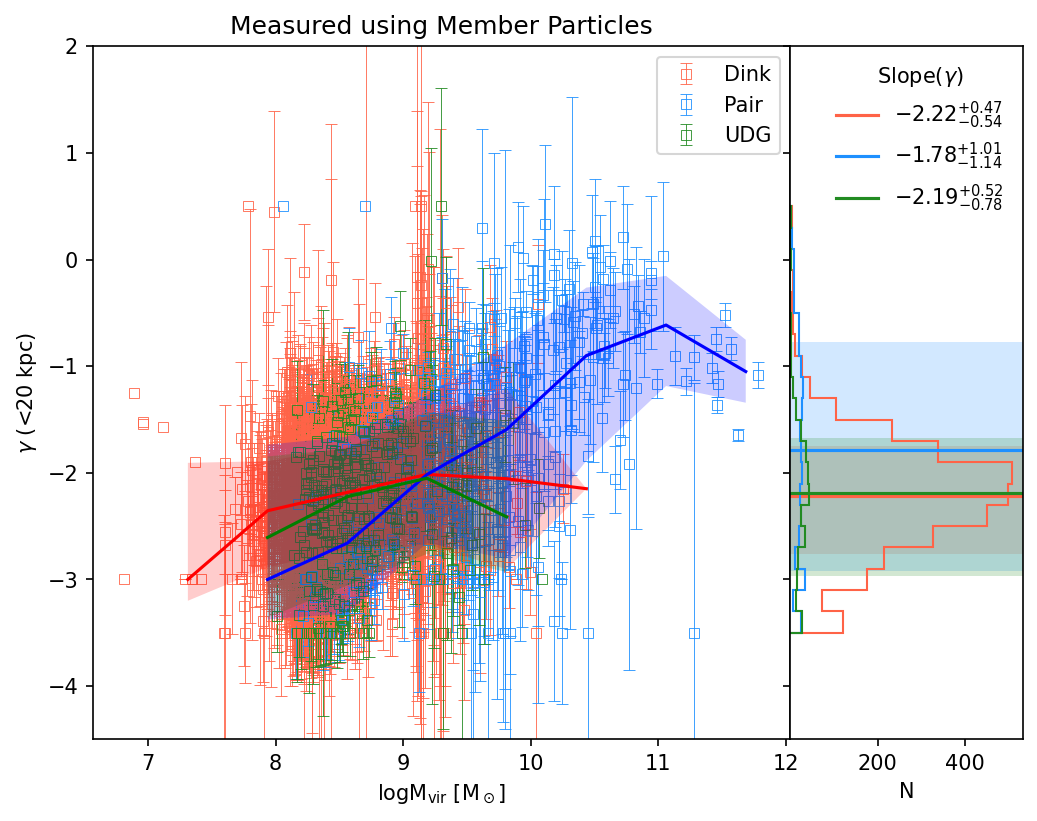

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(8,6), dpi=150, sharey=True, gridspec_kw={'width_ratios': [3, 1]})
ax = axes[0]
ax1 = axes[1]




# Dink
color='tomato'
mask = states=='dink'
sample = allsubs[mask]
slopes = denslops[mask]
errors = densloperrs[mask]

ax.errorbar(np.log10(sample['mvir']), slopes, yerr=errors, ms=5, mec=color,mfc='none', linewidth=0, ecolor=color, mew=0.4, elinewidth=0.4, capthick=0.4, capsize=3, marker='s', label='Dink')
ys = np.zeros(mleng)-1
y16s = np.zeros(mleng)-1
y84s = np.zeros(mleng)-1
for i in range(mleng):
    mask = (sample['mvir'] >= 10**mbins[i])&(sample['mvir'] < 10**mbins[i+1])
    if(np.sum(mask)>0):
        value = slopes[mask]
        y16s[i], ys[i], y84s[i] = np.nanpercentile(value, q=[16,50,84])
    else:
        y16s[i], ys[i], y84s[i] = np.nan,np.nan,np.nan
mask = ~np.isnan(ys)
ax.fill_between(xs[mask], y16s[mask], y84s[mask], fc=colors[1], ec='none', alpha=0.2, zorder=5)
ax.plot(xs[mask], ys[mask], color=colors[1], zorder=6)

ax1.hist(slopes, bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.nanpercentile(slopes, q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)

# Pair
color='dodgerblue'
mask = states=='pair'
sample = allsubs[mask]
slopes = denslops[mask]
errors = densloperrs[mask]

ax.errorbar(np.log10(sample['mvir']), slopes, yerr=errors, ms=5, mec=color,mfc='none', linewidth=0, ecolor=color, mew=0.4, elinewidth=0.4, capthick=0.4, capsize=3, marker='s', label='Pair')
ys = np.zeros(mleng)-1
y16s = np.zeros(mleng)-1
y84s = np.zeros(mleng)-1
for i in range(mleng):
    mask = (sample['mvir'] >= 10**mbins[i])&(sample['mvir'] < 10**mbins[i+1])
    if(np.sum(mask)>0):
        value = slopes[mask]
        y16s[i], ys[i], y84s[i] = np.nanpercentile(value, q=[16,50,84])
    else:
        y16s[i], ys[i], y84s[i] = np.nan,np.nan,np.nan
mask = ~np.isnan(ys)
ax.fill_between(xs[mask], y16s[mask], y84s[mask], fc=colors[2], ec='none', alpha=0.2, zorder=5)
ax.plot(xs[mask], ys[mask], color=colors[2], zorder=6)
ax1.hist(slopes, bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.nanpercentile(slopes, q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)

# UDG
color='forestgreen'
mask = states=='upair'
sample = allsubs[mask]
slopes = denslops[mask]
errors = densloperrs[mask]

ax.errorbar(np.log10(sample['mvir']), slopes, yerr=errors, ms=5, mec=color,mfc='none', linewidth=0, ecolor=color, mew=0.4, elinewidth=0.4, capthick=0.4, capsize=3, marker='s', label='UDG')
ys = np.zeros(mleng)-1
y16s = np.zeros(mleng)-1
y84s = np.zeros(mleng)-1
for i in range(mleng):
    mask = (sample['mvir'] >= 10**mbins[i])&(sample['mvir'] < 10**mbins[i+1])
    if(np.sum(mask)>0):
        value = slopes[mask]
        y16s[i], ys[i], y84s[i] = np.nanpercentile(value, q=[16,50,84])
    else:
        y16s[i], ys[i], y84s[i] = np.nan,np.nan,np.nan
mask = ~np.isnan(ys)
ax.fill_between(xs[mask], y16s[mask], y84s[mask], fc=colors[3], ec='none', alpha=0.2, zorder=5)
ax.plot(xs[mask], ys[mask], color=colors[3], zorder=6)
ax1.hist(slopes, bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.nanpercentile(slopes, q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)

ax.legend()
ax1.legend(title=r'Slope($\gamma$)', frameon=False)
ax.set_xlabel(r'logM$_{\rm vir}$ [M$_\odot$]')
ax.set_ylabel(r'$\gamma$ (<20 kpc)')
ax1.set_xlabel(r'N')
ax1.set_xlim(0.001,)
ax.set_ylim(-4.5,2)
ax.set_title("Measured using Member Particles")
plt.subplots_adjust(wspace=0)
plt.savefig(f"{database}/photo/03_density_slope/03_innerslope_member.png", dpi=400, transparent=False, facecolor='white', bbox_inches='tight', pad_inches=0.1)
plt.show(); plt.close()

# In Rvir

In [10]:
if(density_slope is None):
    denslops_vir = np.zeros(len(allsubs))
    densloperrs_vir = np.zeros(len(allsubs))
    draw=True
    for j, table in tqdm( enumerate(allsubs), total=len(allsubs)):
        state = states[j]
        draw = not os.path.exists(f"{database}/photo/03_density_slope/inner_example_rvir_{state}.png")
        # draw = draw or (not os.path.exists(f"{database}/photo/03_density_slope/inner_weird_rvir_{state}.png"))
        memdm = pklload(f"{database}/parts/insub/nh_dm_{table['Host']:04d}_{table['id']:07d}.pickle")
        memdm = uri.Particle( cut_sphere(memdm, table['x'], table['y'], table['z'], table['rvir']),snap )
        # memdm = uhmi.HaloMaker.read_member_part(snap, table['id'], galaxy=False, target_fields=['x','y','z','m'])
        mem_dist = distance(table, memdm)/snap.unit['kpc']; argsort = np.argsort(mem_dist)
        mem_dist = mem_dist[argsort]; mem_mass = memdm['m'][argsort]
        rvir_kpc = table['rvir']/snap.unit['kpc']
        leng = 15
        
        if(draw):
            rbins2 = np.logspace(np.log10(rvir_kpc/100), np.log10(rvir_kpc), leng+1) # kpc
            rx2 = (rbins2[1:] + rbins2[:-1])/2
            rhos2 = np.zeros(leng)
            mass2 = np.zeros(leng)
            nparts2 = np.zeros(leng)
            for i in range(leng):
                mask2 = (mem_dist >= rbins2[i]) & (mem_dist < rbins2[i+1])
                nparts2[i] = np.sum(mask2)
                mass_in_sphere2 = np.sum(mem_mass[mask2])/snap.unit['Msol']
                mass2[i] = mass_in_sphere2
                vol2 = sphere(rbins2[i+1]) - sphere(rbins2[i])
                rhos2[i] = mass_in_sphere2/vol2 # Msol/kpc^3
            mask2 = rhos2>0
            rx2 = rx2[mask2]; rhos2 = rhos2[mask2]; mass2 = mass2[mask2]; nparts2 = nparts2[mask2]
            ws2 = 1/np.sqrt(nparts2)
            rhoserr2 = rhos2 * ws2
            ws2 /= np.sum(ws2)
            fig,ax = plt.subplots()
            color = 'r' if(state=='dink') else 'b'
            ax.errorbar(rx2/rvir_kpc, rhos2, yerr=rhoserr2, ms=5, mec='grey',mfc='none', ecolor='grey', elinewidth=1, capsize=3, marker='s', lw=0)
        rbins = np.logspace(np.log10(rvir_kpc/100), np.log10(rvir_kpc/50), leng+1) # kpc
        if(rvir_kpc/50 < 0.5):
            rbins = np.logspace(np.log10(0.5), np.log10(2), leng+1)
        rx = (rbins[1:] + rbins[:-1])/2
        rhos = np.zeros(leng)
        mass = np.zeros(leng)
        nparts = np.zeros(leng)
        for i in range(leng):
            mask = (mem_dist >= rbins[i]) & (mem_dist < rbins[i+1])
            nparts[i] = np.sum(mask)
            mass_in_sphere = np.sum(mem_mass[mask])/snap.unit['Msol']
            mass[i] = mass_in_sphere
            vol = sphere(rbins[i+1]) - sphere(rbins[i])
            rhos[i] = mass_in_sphere/vol # Msol/kpc^3
        mask = rhos>0
        rx = rx[mask]; rhos = rhos[mask]; mass = mass[mask]; nparts = nparts[mask]
        ws = 1/np.sqrt(nparts)
        rhoserr = rhos * ws
        ws /= np.sum(ws)
        try: popt, pcov = curve_fit(single, np.log10(rx), np.log10(rhos), p0=[1, -2], bounds=([-np.inf, -3.5], [np.inf, 0.5]), sigma=ws, maxfev=5000, method='trf')
        except: popt = np.zeros(2)*np.nan; pcov = np.zeros((2,2))*np.nan
        chi = chisq( np.log10(rhos), single(np.log10(rx), *popt), ws, ddof=2)

        denslops_vir[j] = popt[-1]
        # print(pcov,np.sqrt(np.diag(pcov))[-1])
        densloperrs_vir[j] = np.sqrt(np.diag(pcov))[-1]

        if(draw):
            ax.errorbar(rx/rvir_kpc, rhos, yerr=rhoserr, ms=5, mec=color,mfc='none', ecolor=color, elinewidth=1, capsize=3, marker='s', zorder=2, lw=0)
            ax.plot(rx/rvir_kpc, 10**single(np.log10(rx), *popt), label=fr"[Inner] $\gamma$={popt[-1]:.2f}$\pm${np.sqrt(np.diag(pcov))[-1]:.2f}, $R^2$={chi:.4f}", ls='-', lw=2, color='black', zorder=3)
            ax.axvspan(ax.get_xlim()[0], 0.5/rvir_kpc, color='grey', alpha=0.2)
            ax.set_xscale('log')
            ax.set_yscale('log')

            ypos = 0.25
            ax.text(0.05, ypos, f"ID={table['id']} ({state})", ha='left', va='center', transform=ax.transAxes, color=color); ypos -= 0.05
            ax.text(0.05, ypos, fr"$\log(M_h/M_\odot)$={np.log10(table['m']):.2f}", ha='left', va='center', transform=ax.transAxes); ypos -= 0.05
            ax.text(0.05, ypos, fr"$\log(M_{{vir}}/M_\odot)$={np.log10(table['mvir']):.2f}", ha='left', va='center', transform=ax.transAxes); ypos -= 0.05
            ax.text(0.05, ypos, fr"$\log(M_{{200}}/M_\odot)$={np.log10(table['m200']):.2f}", ha='left', va='center', transform=ax.transAxes); ypos -= 0.05
            ax.text(0.05, ypos, fr"$R_{{vir}}$={table['rvir']/snap.unit['kpc']:.2f} kpc", ha='left', va='center', transform=ax.transAxes); ypos -= 0.05

            ax.legend()

            ax.set_xlabel(r'$R/R_{vir}$')
            ax.set_ylabel(r'$\rho$ [M$_\odot$ kpc$^{-3}$]')
            if(densloperrs_vir[j]<0.5):
                plt.savefig(f"{database}/photo/03_density_slope/inner_example_rvir_{state}.png", dpi=400, bbox_inches='tight', pad_inches=0.1)
                plt.close()
            elif((chi<0.5) and ((popt[-1]==-3.5)or(popt[-1]==0.5))):
                plt.savefig(f"{database}/photo/03_density_slope/inner_weird_rvir_{state}.png", dpi=400, bbox_inches='tight', pad_inches=0.1)
                plt.close()
            plt.close()
else:
    denslops_vir = density_slope['slope_vir']
    densloperrs_vir = density_slope['err_vir']

  0%|          | 16/3851 [00:00<00:56, 67.93it/s]/tmp/ipykernel_48986/1665795486.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - ssres/sstot
  2%|▏         | 80/3851 [00:00<00:27, 137.59it/s]/tmp/ipykernel_48986/1665795486.py:3: RuntimeWarning: invalid value encountered in double_scalars
  ssres = np.sum( (obs-exp)**2 * weight) / np.sum(weight)
/tmp/ipykernel_48986/1665795486.py:5: RuntimeWarning: invalid value encountered in double_scalars
  sstot = np.sum( (obs-mean)**2 * weight) / np.sum(weight)
  3%|▎         | 97/3851 [00:00<00:25, 145.99it/s]/tmp/ipykernel_48986/1665795486.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - ssres/sstot
100%|██████████| 3851/3851 [00:26<00:00, 142.78it/s]


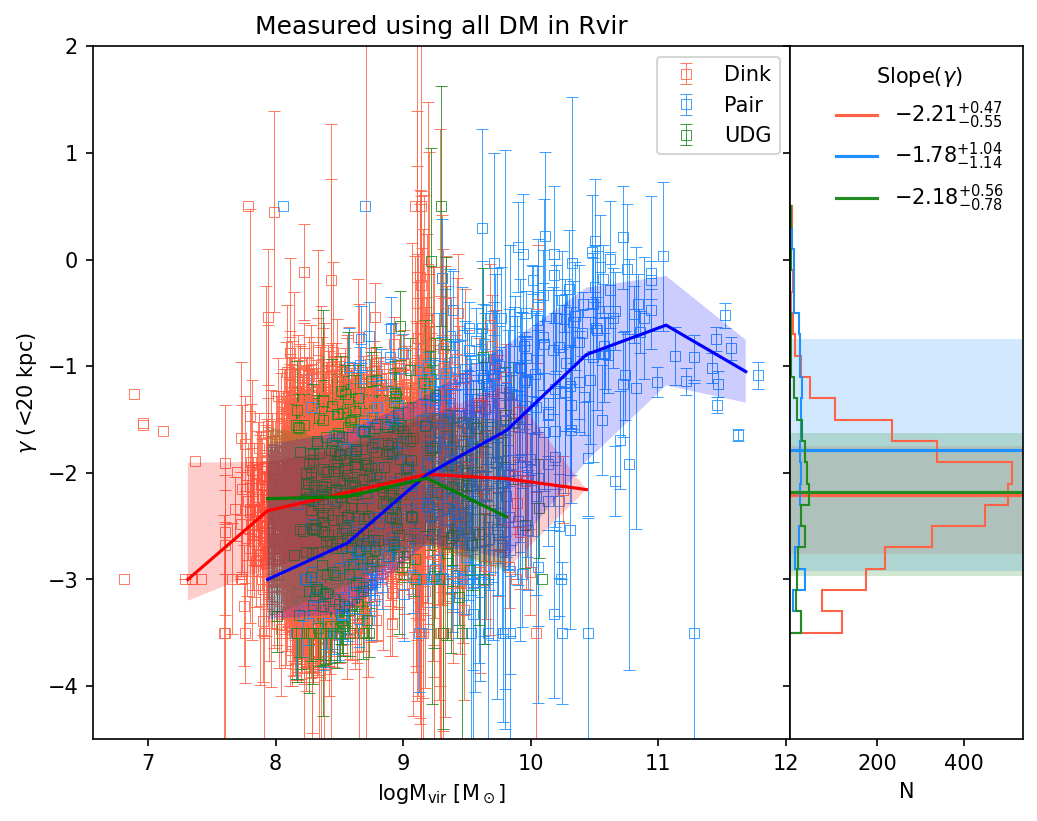

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(8,6), dpi=150, sharey=True, gridspec_kw={'width_ratios': [3, 1]})
ax = axes[0]
ax1 = axes[1]

# Dink
color='tomato'
mask = states=='dink'
sample = allsubs[mask]
slopes = denslops_vir[mask]
errors = densloperrs_vir[mask]

ax.errorbar(np.log10(sample['mvir']), slopes, yerr=errors, ms=5, mec=color,mfc='none', linewidth=0, ecolor=color, mew=0.4, elinewidth=0.4, capthick=0.4, capsize=3, marker='s', label='Dink')
colorcount=1
ys = np.zeros(mleng)-1
y16s = np.zeros(mleng)-1
y84s = np.zeros(mleng)-1
for i in range(mleng):
    mask = (sample['mvir'] >= 10**mbins[i])&(sample['mvir'] < 10**mbins[i+1])
    if(np.sum(mask)>0):
        value = slopes[mask]
        y16s[i], ys[i], y84s[i] = np.nanpercentile(value, q=[16,50,84])
    else:
        y16s[i], ys[i], y84s[i] = np.nan,np.nan,np.nan
mask = ~np.isnan(ys)
ax.fill_between(xs[mask], y16s[mask], y84s[mask], fc=colors[colorcount], ec='none', alpha=0.2, zorder=5)
ax.plot(xs[mask], ys[mask], color=colors[colorcount], zorder=6)
colorcount+=1
ax1.hist(slopes, bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.nanpercentile(slopes, q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)

# Pair
color='dodgerblue'
mask = states=='pair'
sample = allsubs[mask]
slopes = denslops_vir[mask]
errors = densloperrs_vir[mask]

ax.errorbar(np.log10(sample['mvir']), slopes, yerr=errors, ms=5, mec=color,mfc='none', linewidth=0, ecolor=color, mew=0.4, elinewidth=0.4, capthick=0.4, capsize=3, marker='s', label='Pair')
ys = np.zeros(mleng)-1
y16s = np.zeros(mleng)-1
y84s = np.zeros(mleng)-1
for i in range(mleng):
    mask = (sample['mvir'] >= 10**mbins[i])&(sample['mvir'] < 10**mbins[i+1])
    if(np.sum(mask)>0):
        value = slopes[mask]
        y16s[i], ys[i], y84s[i] = np.nanpercentile(value, q=[16,50,84])
    else:
        y16s[i], ys[i], y84s[i] = np.nan,np.nan,np.nan
mask = ~np.isnan(ys)
ax.fill_between(xs[mask], y16s[mask], y84s[mask], fc=colors[colorcount], ec='none', alpha=0.2, zorder=5)
ax.plot(xs[mask], ys[mask], color=colors[colorcount], zorder=6)
colorcount+=1
ax1.hist(slopes, bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.nanpercentile(slopes, q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)

# UDG
color='forestgreen'
mask = states=='upair'
sample = allsubs[mask]
slopes = denslops_vir[mask]
errors = densloperrs_vir[mask]

ax.errorbar(np.log10(sample['mvir']), slopes, yerr=errors, ms=5, mec=color,mfc='none', linewidth=0, ecolor=color, mew=0.4, elinewidth=0.4, capthick=0.4, capsize=3, marker='s', label='UDG')
ys = np.zeros(mleng)-1
y16s = np.zeros(mleng)-1
y84s = np.zeros(mleng)-1
for i in range(mleng):
    mask = (sample['mvir'] >= 10**mbins[i])&(sample['mvir'] < 10**mbins[i+1])
    if(np.sum(mask)>0):
        value = slopes[mask]
        y16s[i], ys[i], y84s[i] = np.nanpercentile(value, q=[16,50,84])
    else:
        y16s[i], ys[i], y84s[i] = np.nan,np.nan,np.nan
mask = ~np.isnan(ys)
ax.fill_between(xs[mask], y16s[mask], y84s[mask], fc=colors[colorcount], ec='none', alpha=0.2, zorder=5)
ax.plot(xs[mask], ys[mask], color=colors[colorcount], zorder=6)
colorcount+=1
ax1.hist(slopes, bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.nanpercentile(slopes, q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)

ax.legend()
ax1.legend(title=r'Slope($\gamma$)', frameon=False)
ax.set_xlabel(r'logM$_{\rm vir}$ [M$_\odot$]')
ax.set_ylabel(r'$\gamma$ (<20 kpc)')
ax1.set_xlabel(r'N')
ax1.set_xlim(0.001,)
ax.set_ylim(-4.5,2)
ax.set_title("Measured using all DM in Rvir")
plt.subplots_adjust(wspace=0)
plt.savefig(f"{database}/photo/03_density_slope/03_innerslope_rvir.png", dpi=400, transparent=False, facecolor='white', bbox_inches='tight', pad_inches=0.1)
plt.show(); plt.close()

## all particles and cells?

In [13]:
if(density_slope is None):
    denslops_tot = np.zeros(len(allsubs))
    densloperrs_tot = np.zeros(len(allsubs))
    draw=True
    for j, table in tqdm( enumerate(allsubs), total=len(allsubs)):
        state = states[j]
        draw = not os.path.exists(f"{database}/photo/03_density_slope/inner_example_total_{state}.png")
        # draw = draw or (not os.path.exists(f"{database}/photo/03_density_slope/inner_weird_total_{state}.png"))
        memdm = pklload(f"{database}/parts/insub/nh_dm_{table['Host']:04d}_{table['id']:07d}.pickle")
        memdm = uri.Particle( cut_sphere(memdm, table['x'], table['y'], table['z'], table['rvir']),snap )
        memstar = pklload(f"{database}/parts/insub/nh_star_{table['Host']:04d}_{table['id']:07d}.pickle")
        memstar = cut_sphere(memstar, table['x'], table['y'], table['z'], table['rvir'])
        memcell = pklload(f"{database}/parts/insub/nh_cell_{table['Host']:04d}_{table['id']:07d}.pickle")
        memcell = uri.Cell(cut_sphere(memcell, table['x'], table['y'], table['z'], table['rvir']),snap)
        dist1 = distance(table, memdm)/snap.unit['kpc']; mass1 = memdm['m']
        dist2 = distance(table, memstar)/snap.unit['kpc']; mass2 = memstar['m']
        dist3 = distance(table, memcell)/snap.unit['kpc']; mass3 = memcell['m']
        mem_dist = np.hstack((dist1, dist2, dist3)); mem_mass = np.hstack((mass1, mass2, mass3))
        argsort = np.argsort(mem_dist)
        mem_dist = mem_dist[argsort]; mem_mass = mem_mass[argsort]
        rvir_kpc = table['rvir']/snap.unit['kpc']
        leng = 15
        
        if(draw):
            rbins2 = np.logspace(np.log10(rvir_kpc/100), np.log10(rvir_kpc), leng+1) # kpc
            rx2 = (rbins2[1:] + rbins2[:-1])/2
            rhos2 = np.zeros(leng)
            mass2 = np.zeros(leng)
            nparts2 = np.zeros(leng)
            for i in range(leng):
                mask2 = (mem_dist >= rbins2[i]) & (mem_dist < rbins2[i+1])
                nparts2[i] = np.sum(mask2)
                mass_in_sphere2 = np.sum(mem_mass[mask2])/snap.unit['Msol']
                mass2[i] = mass_in_sphere2
                vol2 = sphere(rbins2[i+1]) - sphere(rbins2[i])
                rhos2[i] = mass_in_sphere2/vol2 # Msol/kpc^3
            mask2 = rhos2>0
            rx2 = rx2[mask2]; rhos2 = rhos2[mask2]; mass2 = mass2[mask2]; nparts2 = nparts2[mask2]
            ws2 = 1/np.sqrt(nparts2)
            rhoserr2 = rhos2 * ws2
            ws2 /= np.sum(ws2)
            fig,ax = plt.subplots()
            color = 'r' if(state=='dink') else 'b'
            ax.errorbar(rx2/rvir_kpc, rhos2, yerr=rhoserr2, ms=5, mec='grey',mfc='none', ecolor='grey', elinewidth=1, capsize=3, marker='s', lw=0)
        rbins = np.logspace(np.log10(rvir_kpc/100), np.log10(rvir_kpc/50), leng+1) # kpc
        if(rvir_kpc/50 < 0.5):
            rbins = np.logspace(np.log10(0.5), np.log10(2), leng+1)
        rx = (rbins[1:] + rbins[:-1])/2
        rhos = np.zeros(leng)
        mass = np.zeros(leng)
        nparts = np.zeros(leng)
        for i in range(leng):
            mask = (mem_dist >= rbins[i]) & (mem_dist < rbins[i+1])
            nparts[i] = np.sum(mask)
            mass_in_sphere = np.sum(mem_mass[mask])/snap.unit['Msol']
            mass[i] = mass_in_sphere
            vol = sphere(rbins[i+1]) - sphere(rbins[i])
            rhos[i] = mass_in_sphere/vol # Msol/kpc^3
        mask = rhos>0
        rx = rx[mask]; rhos = rhos[mask]; mass = mass[mask]; nparts = nparts[mask]
        ws = 1/np.sqrt(nparts)
        rhoserr = rhos * ws
        ws /= np.sum(ws)
        try: popt, pcov = curve_fit(single, np.log10(rx), np.log10(rhos), p0=[1, -2], bounds=([-np.inf, -3.5], [np.inf, 0.5]), sigma=ws, maxfev=5000, method='trf')
        except: popt = np.zeros(2)*np.nan; pcov = np.zeros((2,2))*np.nan
        chi = chisq( np.log10(rhos), single(np.log10(rx), *popt), ws, ddof=2)

        denslops_tot[j] = popt[-1]
        # print(pcov,np.sqrt(np.diag(pcov))[-1])
        densloperrs_tot[j] = np.sqrt(np.diag(pcov))[-1]

        if(draw):
            ax.errorbar(rx/rvir_kpc, rhos, yerr=rhoserr, ms=5, mec=color,mfc='none', ecolor=color, elinewidth=1, capsize=3, marker='s', zorder=2, lw=0)
            ax.plot(rx/rvir_kpc, 10**single(np.log10(rx), *popt), label=fr"[Inner] $\gamma$={popt[-1]:.2f}$\pm${np.sqrt(np.diag(pcov))[-1]:.2f}, $R^2$={chi:.4f}", ls='-', lw=2, color='black', zorder=3)
            ax.axvspan(ax.get_xlim()[0], 0.5/rvir_kpc, color='grey', alpha=0.2)
            ax.set_xscale('log')
            ax.set_yscale('log')

            ypos = 0.25
            ax.text(0.05, ypos, f"ID={table['id']} ({state})", ha='left', va='center', transform=ax.transAxes, color=color); ypos -= 0.05
            ax.text(0.05, ypos, fr"$\log(M_h/M_\odot)$={np.log10(table['m']):.2f}", ha='left', va='center', transform=ax.transAxes); ypos -= 0.05
            ax.text(0.05, ypos, fr"$\log(M_{{vir}}/M_\odot)$={np.log10(table['mvir']):.2f}", ha='left', va='center', transform=ax.transAxes); ypos -= 0.05
            ax.text(0.05, ypos, fr"$\log(M_{{200}}/M_\odot)$={np.log10(table['m200']):.2f}", ha='left', va='center', transform=ax.transAxes); ypos -= 0.05
            ax.text(0.05, ypos, fr"$R_{{vir}}$={table['rvir']/snap.unit['kpc']:.2f} kpc", ha='left', va='center', transform=ax.transAxes); ypos -= 0.05

            ax.legend()

            ax.set_xlabel(r'$R/R_{vir}$')
            ax.set_ylabel(r'$\rho$ [M$_\odot$ kpc$^{-3}$]')
            if(densloperrs_tot[j]<0.5):
                plt.savefig(f"{database}/photo/03_density_slope/inner_example_total_{state}.png", dpi=400, bbox_inches='tight', pad_inches=0.1)
                plt.close()
            elif((chi<0.5) and ((popt[-1]==-3.5)or(popt[-1]==0.5))):
                plt.savefig(f"{database}/photo/03_density_slope/inner_weird_total_{state}.png", dpi=400, bbox_inches='tight', pad_inches=0.1)
                plt.close()
            plt.close()
else:
    denslops_tot = density_slope['slope_tot']
    densloperrs_tot = density_slope['err_tot']

  0%|          | 14/3851 [00:03<10:33,  6.06it/s] /home/jeon/.conda/envs/jeonpy/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_48986/1665795486.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - ssres/sstot
  2%|▏         | 80/3851 [00:05<01:44, 36.01it/s]/tmp/ipykernel_48986/1665795486.py:3: RuntimeWarning: invalid value encountered in double_scalars
  ssres = np.sum( (obs-exp)**2 * weight) / np.sum(weight)
/home/jeon/.conda/envs/jeonpy/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jeon/.conda/envs/jeonpy/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_48986/166

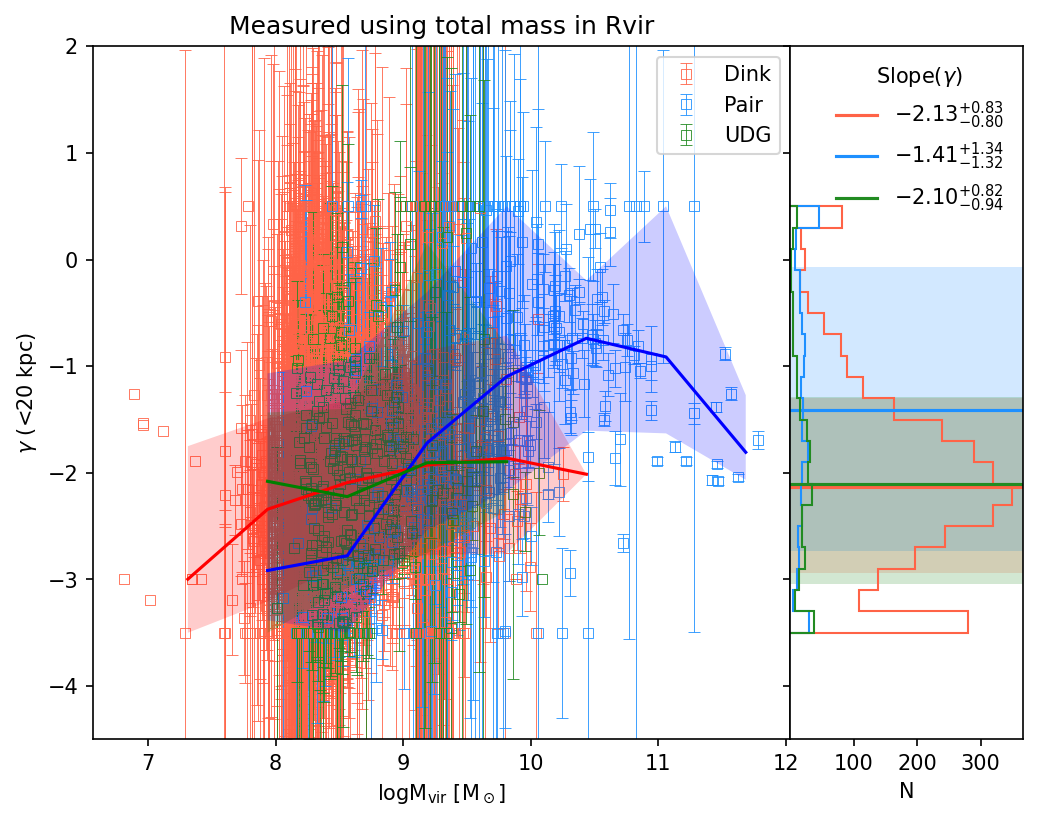

In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(8,6), dpi=150, sharey=True, gridspec_kw={'width_ratios': [3, 1]})
ax = axes[0]
ax1 = axes[1]

# Dink
color='tomato'
mask = states=='dink'
sample = allsubs[mask]
slopes = denslops_tot[mask]
errors = densloperrs_tot[mask]

ax.errorbar(np.log10(sample['mvir']), slopes, yerr=errors, ms=5, mec=color,mfc='none', linewidth=0, ecolor=color, mew=0.4, elinewidth=0.4, capthick=0.4, capsize=3, marker='s', label='Dink')
colorcount=1
ys = np.zeros(mleng)-1
y16s = np.zeros(mleng)-1
y84s = np.zeros(mleng)-1
for i in range(mleng):
    mask = (sample['mvir'] >= 10**mbins[i])&(sample['mvir'] < 10**mbins[i+1])
    if(np.sum(mask)>0):
        value = slopes[mask]
        y16s[i], ys[i], y84s[i] = np.nanpercentile(value, q=[16,50,84])
    else:
        y16s[i], ys[i], y84s[i] = np.nan,np.nan,np.nan
mask = ~np.isnan(ys)
ax.fill_between(xs[mask], y16s[mask], y84s[mask], fc=colors[colorcount], ec='none', alpha=0.2, zorder=5)
ax.plot(xs[mask], ys[mask], color=colors[colorcount], zorder=6)
colorcount+=1
ax1.hist(slopes, bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.nanpercentile(slopes, q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)

# Pair
color='dodgerblue'
mask = states=='pair'
sample = allsubs[mask]
slopes = denslops_tot[mask]
errors = densloperrs_tot[mask]

ax.errorbar(np.log10(sample['mvir']), slopes, yerr=errors, ms=5, mec=color,mfc='none', linewidth=0, ecolor=color, mew=0.4, elinewidth=0.4, capthick=0.4, capsize=3, marker='s', label='Pair')
ys = np.zeros(mleng)-1
y16s = np.zeros(mleng)-1
y84s = np.zeros(mleng)-1
for i in range(mleng):
    mask = (sample['mvir'] >= 10**mbins[i])&(sample['mvir'] < 10**mbins[i+1])
    if(np.sum(mask)>0):
        value = slopes[mask]
        y16s[i], ys[i], y84s[i] = np.nanpercentile(value, q=[16,50,84])
    else:
        y16s[i], ys[i], y84s[i] = np.nan,np.nan,np.nan
mask = ~np.isnan(ys)
ax.fill_between(xs[mask], y16s[mask], y84s[mask], fc=colors[colorcount], ec='none', alpha=0.2, zorder=5)
ax.plot(xs[mask], ys[mask], color=colors[colorcount], zorder=6)
colorcount+=1
ax1.hist(slopes, bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.nanpercentile(slopes, q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)

# UDG
color='forestgreen'
mask = states=='upair'
sample = allsubs[mask]
slopes = denslops_tot[mask]
errors = densloperrs_tot[mask]

ax.errorbar(np.log10(sample['mvir']), slopes, yerr=errors, ms=5, mec=color,mfc='none', linewidth=0, ecolor=color, mew=0.4, elinewidth=0.4, capthick=0.4, capsize=3, marker='s', label='UDG')
ys = np.zeros(mleng)-1
y16s = np.zeros(mleng)-1
y84s = np.zeros(mleng)-1
for i in range(mleng):
    mask = (sample['mvir'] >= 10**mbins[i])&(sample['mvir'] < 10**mbins[i+1])
    if(np.sum(mask)>0):
        value = slopes[mask]
        y16s[i], ys[i], y84s[i] = np.nanpercentile(value, q=[16,50,84])
    else:
        y16s[i], ys[i], y84s[i] = np.nan,np.nan,np.nan
mask = ~np.isnan(ys)
ax.fill_between(xs[mask], y16s[mask], y84s[mask], fc=colors[colorcount], ec='none', alpha=0.2, zorder=5)
ax.plot(xs[mask], ys[mask], color=colors[colorcount], zorder=6)
colorcount+=1
ax1.hist(slopes, bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.nanpercentile(slopes, q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)

ax.legend()
ax1.legend(title=r'Slope($\gamma$)', frameon=False)
ax.set_xlabel(r'logM$_{\rm vir}$ [M$_\odot$]')
ax.set_ylabel(r'$\gamma$ (<20 kpc)')
ax1.set_xlabel(r'N')
ax1.set_xlim(0.001,)
ax.set_ylim(-4.5,2)
ax.set_title("Measured using total mass in Rvir")
plt.subplots_adjust(wspace=0)
plt.savefig(f"{database}/photo/03_density_slope/03_innerslope_total.png", dpi=400, transparent=False, facecolor='white', bbox_inches='tight', pad_inches=0.1)
plt.show(); plt.close()

In [15]:
if(density_slope is None):
    dtype = [('subid','<i4'),('slope_mem','<f8'),('err_mem','<f8'),('slope_vir','<f8'),('err_vir','<f8'),('slope_tot','<f8'),('err_tot','<f8')]
    density_slope = np.zeros(len(allsubs), dtype=dtype)
    density_slope['subid'] = allsubs['id']
    density_slope['slope_mem'] = denslops
    density_slope['err_mem'] = densloperrs
    density_slope['slope_vir'] = denslops_vir
    density_slope['err_vir'] = densloperrs_vir
    density_slope['slope_tot'] = denslops_tot
    density_slope['err_tot'] = densloperrs_tot
    pklsave(density_slope, f"{database}/03_inner_slope.pickle", overwrite=True)